In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy as scipy
import seaborn as sns
import decimal
import glob as glob
from scipy.stats import norm

In [2]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    sns.despine()
    sns.set_style("ticks")
    
set_style()

<Figure size 432x288 with 0 Axes>

In [3]:
h2kcal = 627.509
jmol2kcal = 0.000239006
R = 8.3145 #J /K*mol

In [4]:
def round_scientific(x):
    y = []
    for i in x:
        y.append('%.3E' % decimal.Decimal(i))
    return y

In [5]:
def pick_set(x,exclude):
    # Scans list x, returns a list with strings in pick
    check = [i for i in x if any([e for e in exclude if e in i])]
    return check

# Include this list, for concerted replicas
dpt = ['rep_101', 'rep_115', 'rep_122']

In [7]:
raw_elec_txt = sorted(glob.glob('../results/*_e.txt'))

raw_e_reac = pick_set((pd.read_csv(raw_elec_txt[0], header=None)[0]), dpt)
raw_e_ts1  = pick_set((pd.read_csv(raw_elec_txt[1], header=None)[0]), dpt)
raw_e_prod = pick_set((pd.read_csv(raw_elec_txt[4], header=None)[0]), dpt)

In [8]:
raw_e_reac

['rep_101/reactant/reac_opt_sum.txt: Final converged energy:    -979.078206317702',
 'rep_115/reactant/reac_opt_sum.txt: Final converged energy:    -981.108189314690',
 'rep_122/reactant/reac_opt_sum.txt: Final converged energy:    -977.730195628763']

In [9]:
raw_e_ts1

['rep_101/dimer/ts1/dimer_sum.txt: Final converged energy:    -979.056560914106',
 'rep_115/dimer/ts1/dimer_sum.txt: Final converged energy:    -981.083477676704',
 'rep_122/dimer/ts1/dimer_sum.txt: Final converged energy:    -977.700326231912']

In [10]:
raw_e_prod

['rep_101/product/prod_opt_sum.txt: Final converged energy:    -979.060479526801',
 'rep_115/product/prod_opt_sum.txt: Final converged energy:    -981.089596812494',
 'rep_122/product/prod_opt_sum.txt: Final converged energy:    -977.710449173874']

In [11]:
def crunch_elec(x):
    e_list = []
    for i in np.arange(len(x)):
        e_list.append(float(x[i][-17:]))
    e_list = np.array(e_list)    
    return e_list

In [12]:
h_e_reac = crunch_elec(raw_e_reac)
h_e_ts1  = crunch_elec(raw_e_ts1)
h_e_prod = crunch_elec(raw_e_prod)

In [13]:
round(h_e_reac.mean(), 4) , round(h_e_reac.std(), 4)

(-979.3055, 1.3884)

In [14]:
round(h_e_ts1.mean(), 4) , round(h_e_ts1.std(), 4)

(-979.2801, 1.3902)

In [15]:
round(h_e_prod.mean(), 4) , round(h_e_prod.std(), 4)

(-979.2868, 1.3888)

In [16]:
d_hartree_e = { 'Reactant':h_e_reac, 'TS1':h_e_ts1, 'Product':h_e_prod}

print(pd.DataFrame(data=d_hartree_e).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    Reactant &         TS1 &     Product \\
\midrule
0 & -979.078206 & -979.056561 & -979.060480 \\
1 & -981.108189 & -981.083478 & -981.089597 \\
2 & -977.730196 & -977.700326 & -977.710449 \\
\bottomrule
\end{tabular}



In [17]:
len(h_e_reac), len(h_e_ts1), len(h_e_prod)

(3, 3, 3)

In [19]:
e_reac = (h_e_reac - h_e_reac)*h2kcal
e_ts1  = (h_e_ts1 - h_e_reac)*h2kcal
e_prod = (h_e_prod - h_e_reac)*h2kcal

In [20]:
e_ts1.max()

18.743315348599648

In [21]:
e_ts1.min()

13.582685565147223

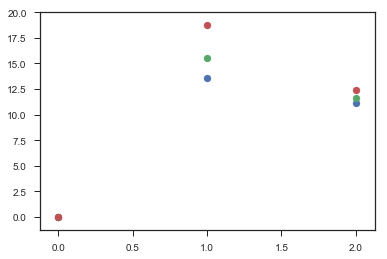

In [22]:
plt.scatter(x=[0,1,2], y=[e_reac[0], e_ts1[0], e_prod[0]])
plt.scatter(x=[0,1,2], y=[e_reac[1], e_ts1[1], e_prod[1]])
plt.scatter(x=[0,1,2], y=[e_reac[2], e_ts1[2], e_prod[2]])

In [23]:
raw_gibbs_f1 = sorted(glob.glob('../results/rep_???/rate/k1f/free_energy_barrier'))
raw_gibbs_r1 = sorted(glob.glob('../results/rep_???/rate/k1r/free_energy_barrier'))

raw_gibbs_f1 = pick_set(raw_gibbs_f1, dpt)
raw_gibbs_r1 = pick_set(raw_gibbs_r1, dpt)

In [24]:
raw_arrhenius_f1 = sorted(glob.glob('../results/rep_???/rate/k1f/arrhenius'))
raw_arrhenius_r1 = sorted(glob.glob('../results/rep_???/rate/k1r/arrhenius'))

raw_arrhenius_f1 = pick_set(raw_arrhenius_f1, dpt)
raw_arrhenius_r1 = pick_set(raw_arrhenius_r1, dpt)

In [25]:
def crunch_gibbs(x):
    final_list = []
    for i in np.arange(len(x)):
        df = pd.read_csv(x[i], skiprows=1, header=None, delim_whitespace=True)
        df[2] = df[1]*h2kcal
        df.columns = ['Temp', 'H', 'kcal']
        kcal = float(df['kcal'])
        final_list.append(kcal)
    final_list = np.array(final_list)      
    return final_list

In [26]:
gibbs_f1 = crunch_gibbs(raw_gibbs_f1)
gibbs_r1 = crunch_gibbs(raw_gibbs_r1)

In [27]:
gibbs_r1.mean(), gibbs_r1.std()

(1.0133394878726953, 1.450876041256122)

In [28]:
gibbs_ts1  = gibbs_f1
gibbs_prod  = gibbs_ts1 - gibbs_r1

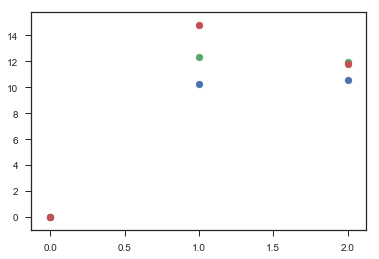

In [29]:
plt.scatter(x=[0,1,2], y=[e_reac[0], gibbs_ts1[0], gibbs_prod[0]])
plt.scatter(x=[0,1,2], y=[e_reac[1], gibbs_ts1[1], gibbs_prod[1]])
plt.scatter(x=[0,1,2], y=[e_reac[2], gibbs_ts1[2], gibbs_prod[2]])

In [30]:
gibbs_ts1.mean(), gibbs_ts1.std()

(12.457050543846208, 1.8628383771522998)

In [31]:
gibbs_ts1 - gibbs_prod

array([-0.34878236,  0.3654798 ,  3.02332102])

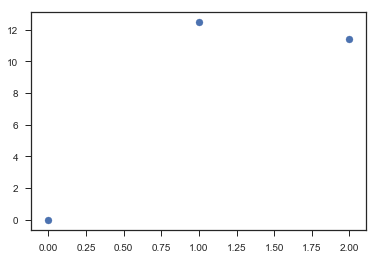

In [32]:
plt.scatter(x=[0,1,2], y=[0, gibbs_ts1.mean(), gibbs_prod.mean()])

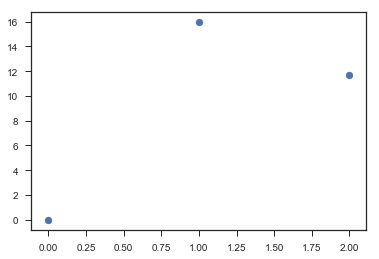

In [33]:
plt.scatter(x=[0,1,2], y=[0, e_ts1.mean(), e_prod.mean()])

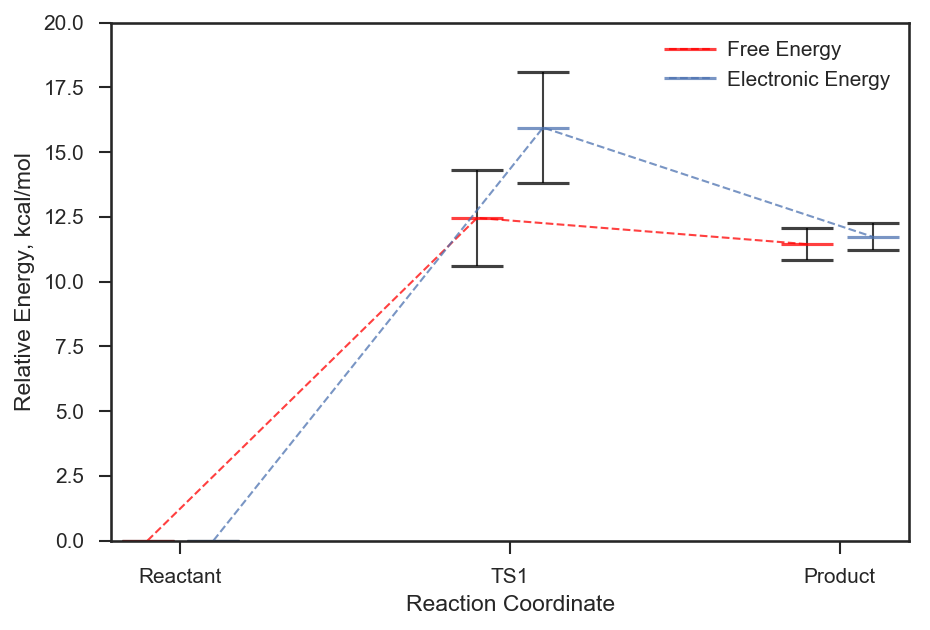

In [34]:
rxn_coord1 = ['Reactant','TS1', 'Product']

y_pos = [ 0, gibbs_ts1.mean(), gibbs_prod.mean()]
error = [ 0, gibbs_ts1.std(), gibbs_prod.std()]

y_pos_e = [ 0, e_ts1.mean(), e_prod.mean()]
error_e = [ 0, e_ts1.std(), e_prod.std()]

x_pos = np.arange(len(rxn_coord1))

fig, ax = plt.subplots(dpi=150)

ax.errorbar(x_pos,y_pos,yerr=error, ecolor='black',capsize=12.5, alpha=0.75, marker='_',ms=25,mew=1.5, ls='--', lw=1, label='Free Energy', color='red' )
ax.errorbar(x_pos+0.2,y_pos_e,yerr=error_e, ecolor='black',capsize=12.5, alpha=0.75, marker='_',ms=25,mew=1.5, ls='--', lw=1, label='Electronic Energy', )

plt.ylim(0,20)

ax.set_xticks(x_pos+0.1)
ax.set_xticklabels(rxn_coord1)
ax.set_xlabel('Reaction Coordinate')

#ax.set_title('Concerted Double Proton Transfer in G:C')
ax.set_ylabel('Relative Energy, kcal/mol')

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]

#plt.axhline(5.1, color='black')
#plt.axvline(0, color='black')

# Run once with white grid, then again with dark grid
#sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style("darkgrid", {'grid.linestyle': '--'})

plt.legend(handles, labels, loc='upper right', framealpha=0)
plt.tight_layout(0)
plt.show()
fig.savefig('qmmm_rxn_coord_gc_concerted.png', transparent=True)

In [35]:
def crunch_rate(x):
    final_list = []
    for i in np.arange(len(x)):
        df = pd.read_csv(x[i], header=None, delim_whitespace=True, skiprows=2)
        df = np.float((df[1])[1])
        final_list.append(df)
    final_list=np.array(final_list)    
    return final_list

In [36]:
rate_f1 = crunch_rate(raw_arrhenius_f1)
rate_r1 = crunch_rate(raw_arrhenius_r1)

/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


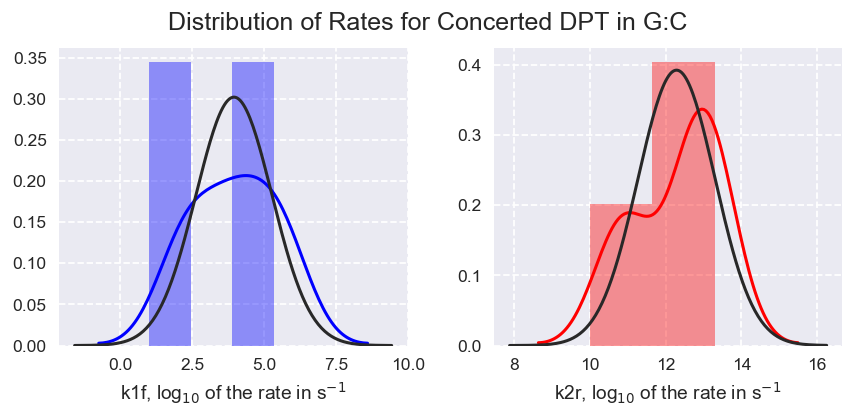

In [37]:
# plot
f, axes = plt.subplots(1, 2, figsize=(7, 3.5), sharex=False, dpi=125)

BinMin, BinMax = int(rate_f1.min())-1, int(rate_f1.max())+1
newBins = np.arange(BinMin, BinMax,1.45)
sns.distplot( rate_f1 , color="blue", ax=axes[0], fit=norm, kde=True, norm_hist=True, bins=newBins, axlabel='k1f, log$_{10}$ of the rate in s$^{−1}$')

BinMin, BinMax = int(rate_r1.min()), int(rate_r1.max())+1
newBins = np.arange(BinMin, BinMax,1.65)
sns.distplot( rate_r1 , color="red", ax=axes[1], fit=norm, kde=True, norm_hist=True, bins=newBins, axlabel='k2r, log$_{10}$ of the rate in s$^{−1}$')

plt.suptitle('Distribution of Rates for Concerted DPT in G:C')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


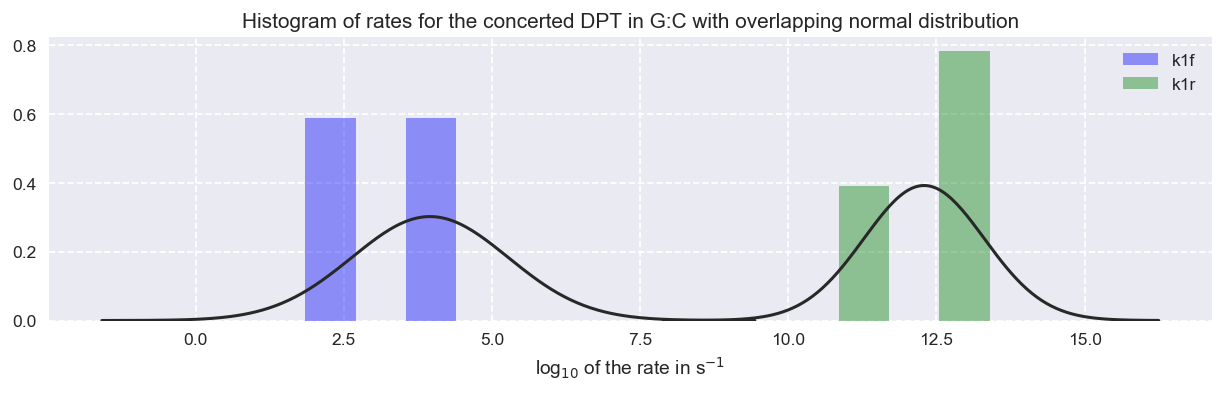

In [38]:
# plot
plt.figure(figsize=(12, 3), dpi=125)

BinMin, BinMax = int(rate_f1.min())-1, int(rate_f1.max())+1
newBins = np.arange(BinMin, BinMax,0.85)
sns.distplot( rate_f1 , color="blue", fit=norm, kde=None, norm_hist=True, bins=newBins, label='k1f')

BinMin, BinMax = int(rate_r1.min()), int(rate_r1.max())+1
newBins = np.arange(BinMin, BinMax,0.85)
sns.distplot( rate_r1 , color="green", fit=norm, kde=None, norm_hist=True,  bins=newBins, label='k1r')

plt.xlabel('log$_{10}$ of the rate in s$^{−1}$')
plt.title('Histogram of rates for the concerted DPT in G:C with overlapping normal distribution')
plt.legend()


In [39]:
#f_298k_s = 10**np.array(f_298k_log)
#r_298k_s = 10**np.array(r_298k_log)
f1_s = 10**(rate_f1)
r1_s = 10**(rate_r1)

keq=f1_s/r1_s

t_gc_s = 1/f1_s
t_gct_s = 1/r1_s

t_half_gc = np.log(2)/f1_s
t_half_gct = np.log(2)/r1_s


In [40]:
f1_s

array([3.47496093e+05, 1.02885227e+04, 2.04059609e+02])

In [41]:
f1_s, r1_s

(array([3.47496093e+05, 1.02885227e+04, 2.04059609e+02]),
 array([1.78877094e+13, 5.42811008e+12, 7.68347010e+10]))

In [42]:
t_half_gct

array([3.87499129e-14, 1.27695859e-13, 9.02127778e-12])

In [43]:
f1_s/r1_s

array([1.94265283e-08, 1.89541527e-09, 2.65582616e-09])

In [44]:
(f1_s/r1_s).mean()

7.992589913297245e-09

In [45]:
((np.log10(f1_s)).mean(), np.log10(f1_s).std(), np.log10(f1_s).std() / np.log10(f1_s).mean() * 100)

(3.9543533321853332, 1.3197663484875006, 33.37502336338127)

In [46]:
np.log10(r1_s).mean(), np.log10(r1_s).std(), np.log10(r1_s).std() / np.log10(r1_s).mean() * 100

(12.290920260573335, 1.0159856441765729, 8.266147876946524)

In [47]:
np.log10(f1_s/r1_s).mean(), np.log10(f1_s/r1_s).std(), np.log10(f1_s/r1_s).std() / np.log10(f1_s/r1_s).mean() * 100

(-8.336566928388, 0.44594353759293365, -5.349246775364922)

In [48]:
d_kinetics = { 'k1f':f1_s, 'k1r':r1_s, 'keq':keq, 'gc_t':t_gc_s, 'gc_taut_t':t_gct_s, 't_half_gc':t_half_gc, 't_half_gct':t_half_gct }

df_kinetics = pd.DataFrame(data=d_kinetics)
df_kinetics

,k1f,k1r,keq,gc_t,gc_taut_t,t_half_gc,t_half_gct
0,347496.092545,1.788771e+13,1.942653e-08,0.000003,5.590431e-14,0.000002,3.874991e-14
1,10288.522713,5.428110e+12,1.895415e-09,0.000097,1.842262e-13,0.000067,1.276959e-13
2,204.059609,7.683470e+10,2.655826e-09,0.004901,1.301495e-11,0.003397,9.021278e-12


In [49]:
df_kinetics['keq'].mean()

7.992589913297245e-09

In [50]:
def print_results(x, y=str):
    return y, 'mean', format(x[y].mean(), "10.2E"), 'std', format(x[y].std(),"10.2E"), 'std%', round(x[y].std()/x[y].mean()*100, 1)

In [51]:
print_results(df_kinetics, 'k1f')

('k1f', 'mean', '  1.19E+05', 'std', '  1.98E+05', 'std%', 165.6)

In [52]:
print_results(df_kinetics, 'k1r')

('k1r', 'mean', '  7.80E+12', 'std', '  9.14E+12', 'std%', 117.2)

In [53]:
print_results(df_kinetics, 'keq')

('keq', 'mean', '  7.99E-09', 'std', '  9.91E-09', 'std%', 124.0)

In [54]:
print_results(df_kinetics, 'gc_t')

('gc_t', 'mean', '  1.67E-03', 'std', '  2.80E-03', 'std%', 168.0)

In [55]:
print_results(df_kinetics, 'gc_taut_t')

('gc_taut_t', 'mean', '  4.42E-12', 'std', '  7.45E-12', 'std%', 168.5)

In [56]:
print_results(df_kinetics, 't_half_gc')

('t_half_gc', 'mean', '  1.16E-03', 'std', '  1.94E-03', 'std%', 168.0)

In [57]:
print_results(df_kinetics, 't_half_gct')

('t_half_gct', 'mean', '  3.06E-12', 'std', '  5.16E-12', 'std%', 168.5)

In [58]:
d_thermo = { 'ts1':gibbs_ts1, 'prod':gibbs_prod }
df_thermo = pd.DataFrame(data=d_thermo)
df_thermo['prod'].mean()

11.44371105597351

In [59]:
e_ts1.mean(), e_ts1.std(), (e_ts1.std()/e_ts1.mean())*100

(15.944258718234943, 2.129408178365032, 13.355328811427873)

In [60]:
e_prod.mean(), e_prod.std(), (e_prod.std()/e_prod.mean())*100

(11.72725381761265, 0.5191499050901845, 4.426866793916372)

In [61]:
keq.mean(), keq.std()

(7.992589913297245e-09, 8.09097301973519e-09)

In [62]:
(keq*0.12).mean(), (keq*0.12).std()

(9.591107895956694e-10, 9.709167623682227e-10)

In [63]:
(keq*(1.5*10**9)).mean(), (keq*(1.5*10**9)).std()

(11.988884869945865, 12.136459529602783)

In [64]:
# concerted
(1.0773020577989207e-08, 1.7276265142531393e-08)

(1.0773020577989207e-08, 1.7276265142531393e-08)

In [65]:
(keq.mean()*0.12 + (1.0773020577989207e-08)*0.84 )

1.0008448075106602e-08

In [66]:
# Defines % conc after 1 s
def taut_conc(kf, kr, t=1):
    prod_init = 0
    reac_init = 1
    conc=((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t))*100
    return conc

In [67]:
taut_conc(f1_s[0:], r1_s[0:])

array([1.94265279e-06, 1.89541526e-07, 2.65582616e-07])

In [68]:
# iterates through time (x) and returns % conc after 1 s (y)
def time_max_conc(kf, kr):
    prod_init = 0
    reac_init = 1
    log_t= np.logspace(-17,0,1000)
    
    x, y = [], []
    for t in log_t:
        x.append(t), y.append((((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t)))*100)
    
    return x,y

# Finds the first case for (y) value to equal y[-1]
def turning_point(x):
    for i in np.arange(len(x[1])):
        if x[1][i] == x[1][-1]:
            break
    return x[0][i]

In [69]:
# The times at which conc reaches eqlm
turning_points = []
for i in np.arange(len(f1_s)):
    f_values = time_max_conc(f1_s[i], r1_s[i])
    turning_points.append(turning_point(f_values))
    
#print(turning_points)

In [70]:
np.array(turning_points).mean(), np.array(turning_points).std()

(1.669842901686271e-10, 2.2961101801623919e-10)

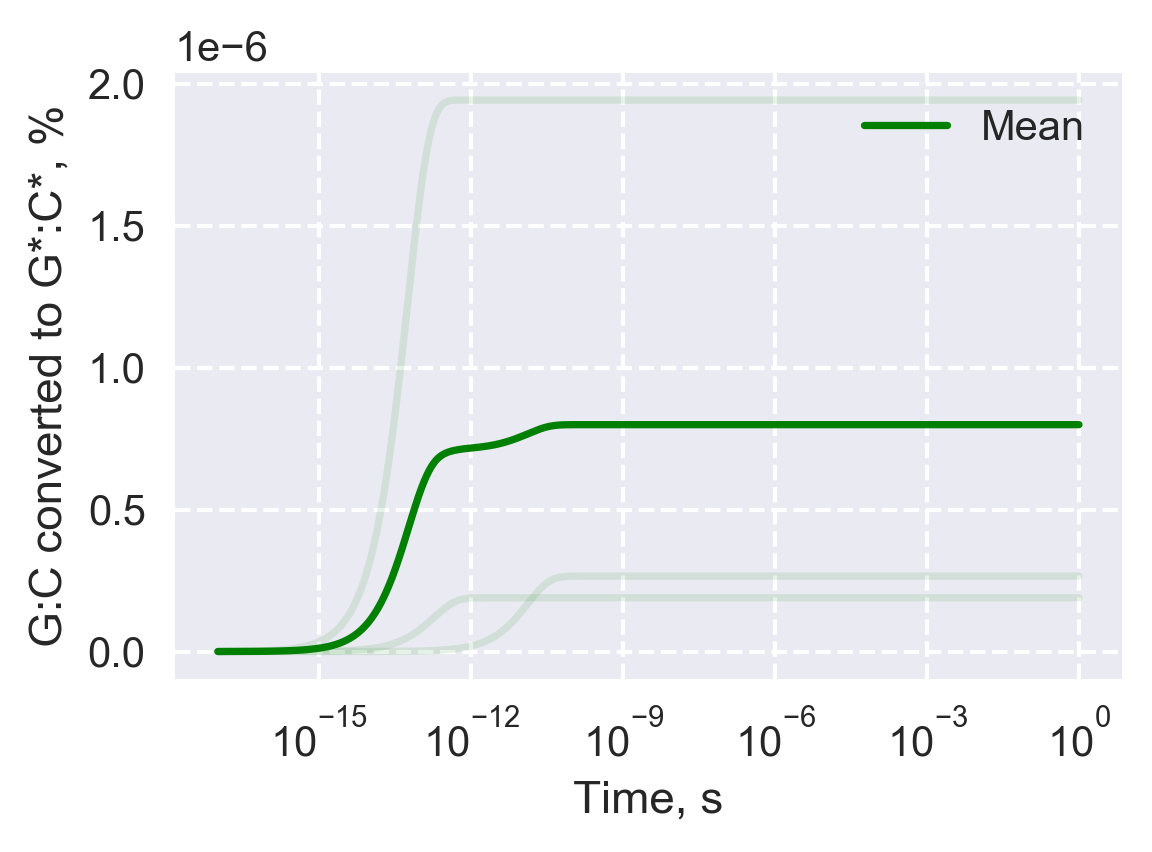

In [71]:
# Create a list of lists with all concentrations 
concs = []
for i in np.arange(len(f1_s)):
    concs.append(time_max_conc(f1_s[i], r1_s[i])[1])

# Create a list of lists with the mean concs at each time, t, and stdev
concs_mean = []
std_mean = []

for n in np.arange(len(concs[0])):
    lst2 = [item[n] for item in concs]
    mean = np.array(lst2).mean()
    std = np.array(lst2).std()
    concs_mean.append(mean)
    std_mean.append(std)

log_t= np.logspace(-17,0,1000)

plt.figure(figsize=(4,3), dpi=300)

plt.plot( log_t, concs_mean, 'green')
plt.xscale('log')

plt.legend(['Mean'], loc='upper right')

for i in np.arange(len(f1_s)):
    x, y = time_max_conc(f1_s[i], r1_s[i])
    plt.plot(x,y, 'green', alpha=0.1)
    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.yticks(np.linspace(0, 2e-6, 5))
plt.ylabel('G:C converted to G*:C*, %')# r'$\times 10^{-6}$')
plt.xlabel('Time, s')
plt.tight_layout()

In [72]:
concs_mean[-1]

7.992589783951909e-07

In [73]:
std_mean[-1]

8.090972844416069e-07

In [74]:
kf = f1_s.mean()
kr = r1_s.mean()
prod_init = 0
reac_init = 1
t = 1

((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t))*100

1.5303465228284905e-06

In [75]:
kf = f1_s.std()
kr = r1_s.std()
prod_init = 0
reac_init = 1
t = 1

((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t))*100

2.1628936515882843e-06

In [76]:
prod_init = 0
reac_init = 1
#t = 1
log_t = np.logspace(-17,0,1000)
log_t

times, concs=[],[]
for n in np.arange(len(f1_s)):
    kf = np.array(f1_s[n])
    kr = np.array(r1_s[n])
    

    x, y = [], []
    for t in log_t:
        x.append(t), y.append((((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t)))*100)
    
    times.append(x)
    concs.append(y)
    
concs_mean = []
std_mean = []

for n in np.arange(len(concs[0])):
    lst2 = [item[n] for item in concs]
    mean = np.array(lst2).mean()
    std = np.array(lst2).std()
    concs_mean.append(mean)
    std_mean.append(std)

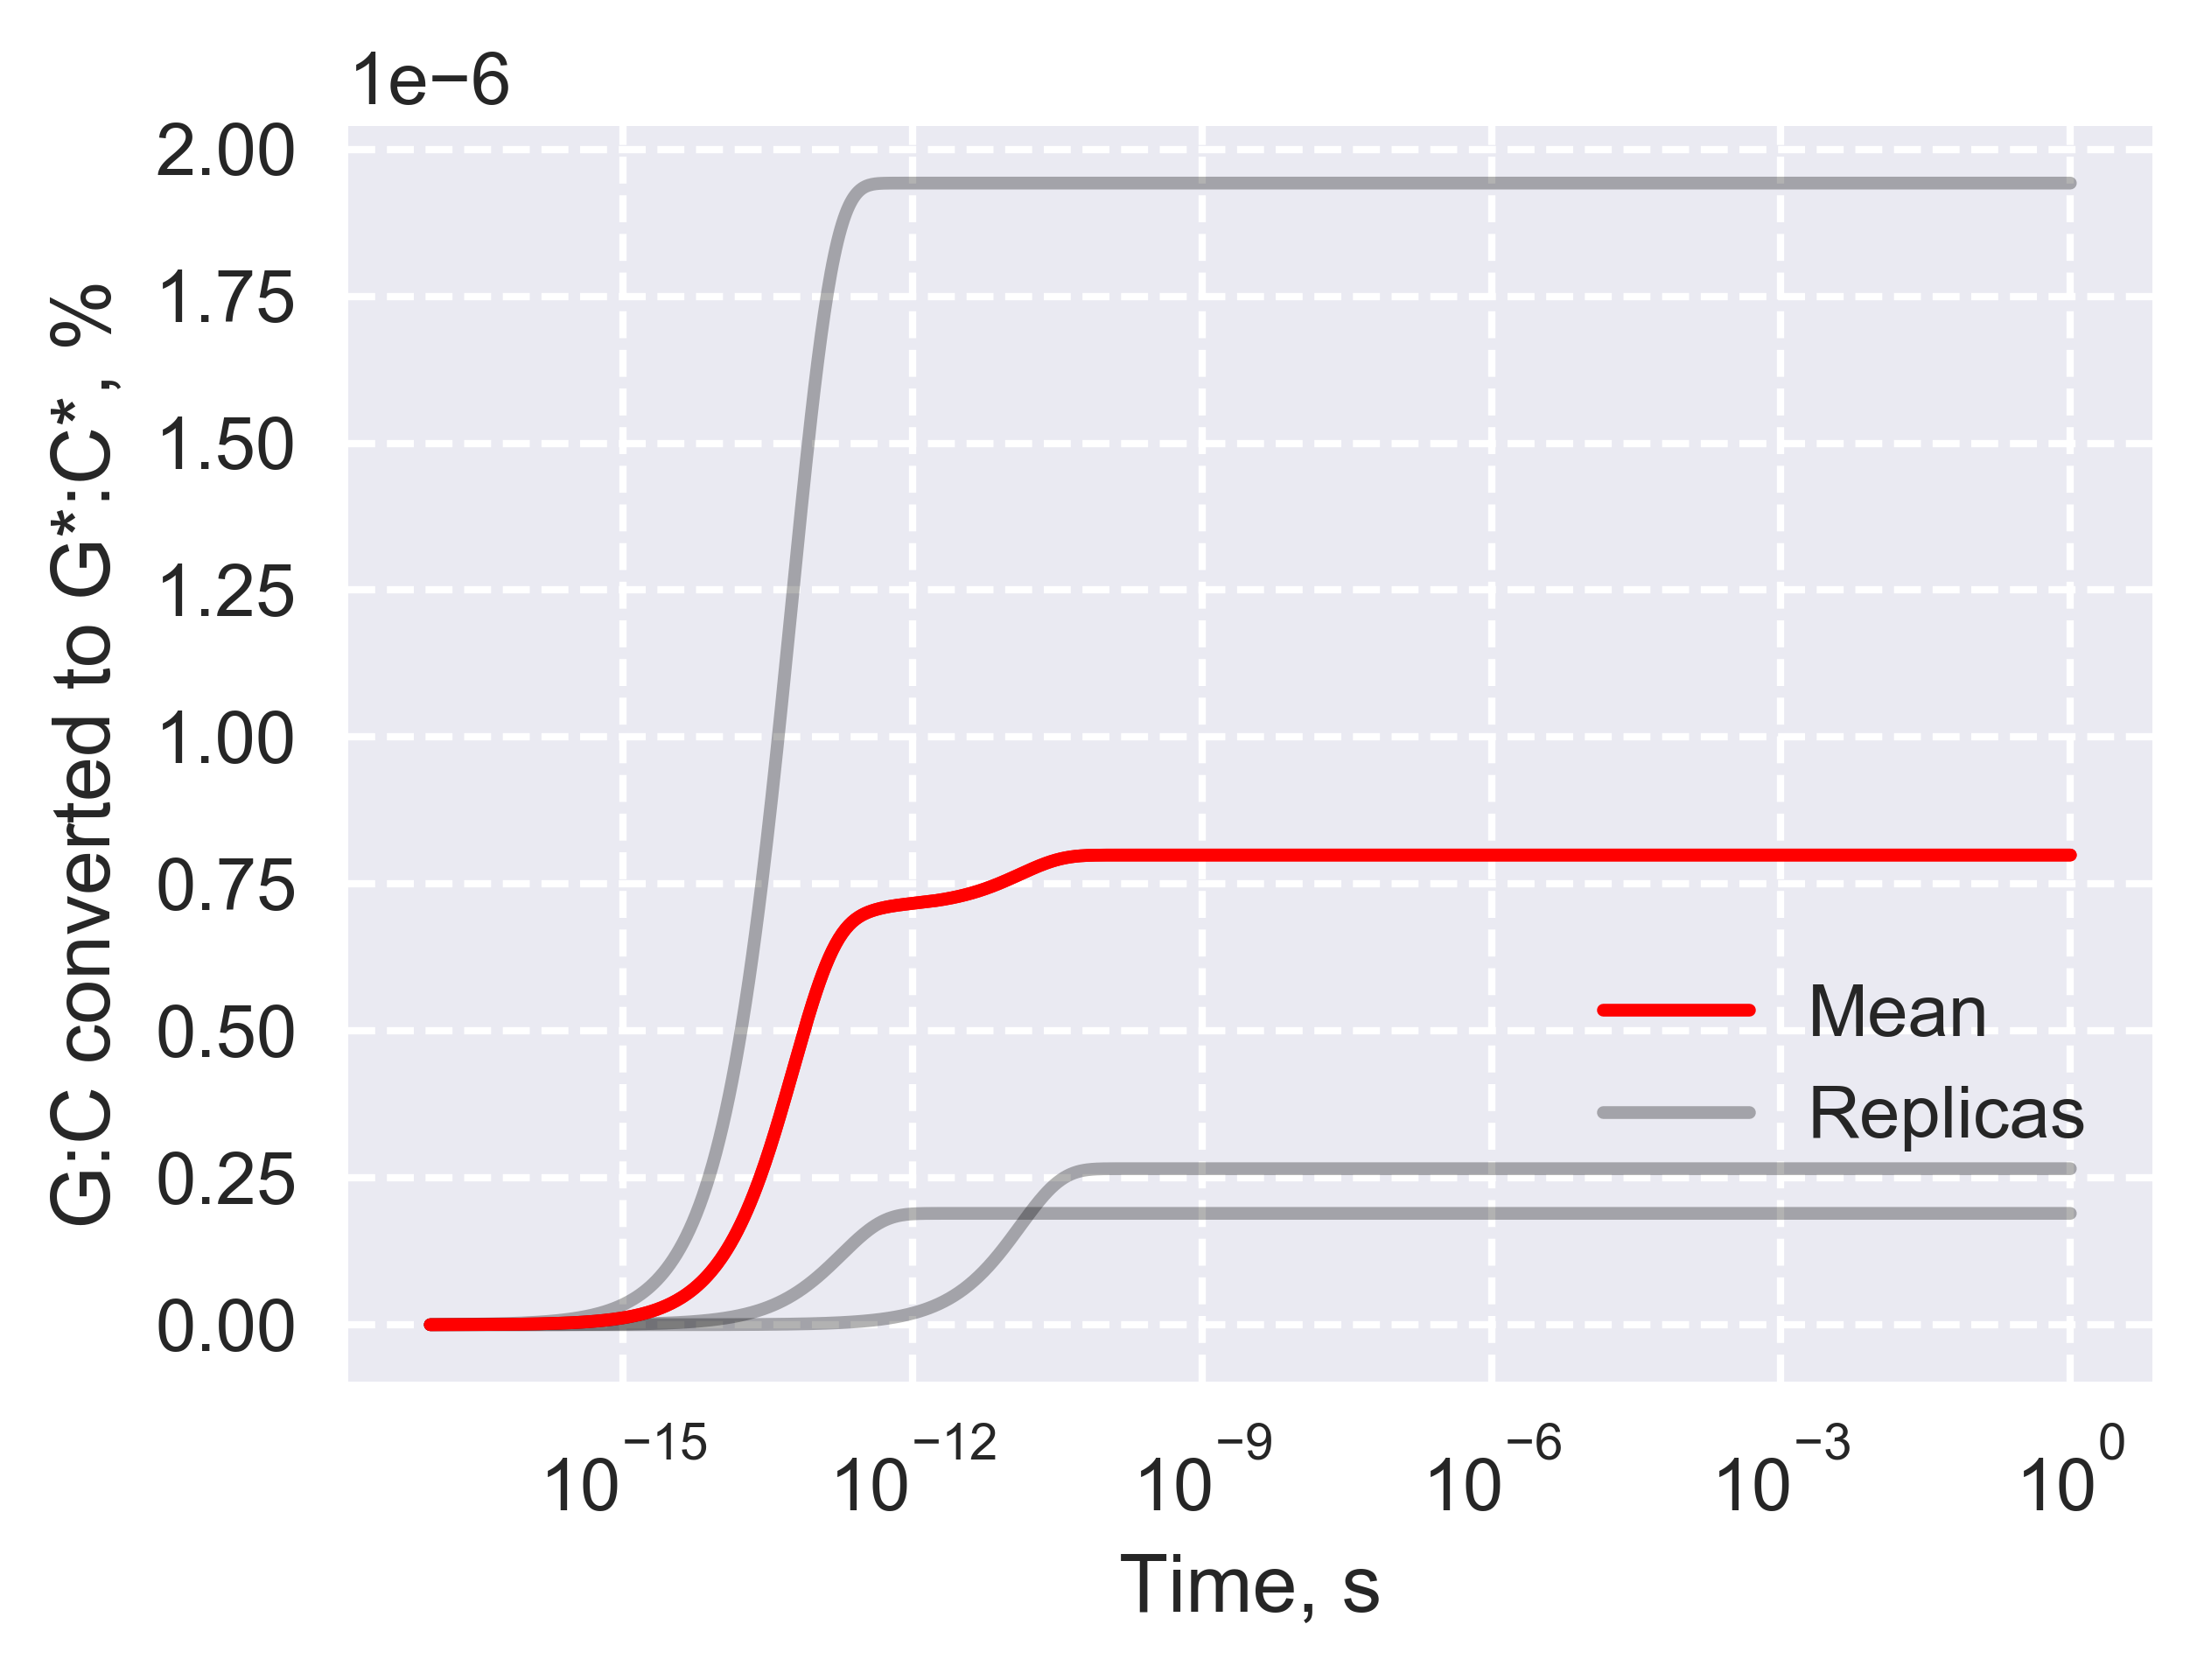

In [77]:
kf = f1_s.mean()
kr = r1_s.mean()
prod_init = 0
reac_init = 1-prod_init

log_t = np.logspace(-17,0,1000)
log_t

plt.figure(figsize=(4,3), dpi=600)

x, y = [], []
for t in log_t:
    x.append(t), y.append((((kf*reac_init - kr*prod_init)/(kf+kr))*(1 - np.exp(-(kf+kr)*t)))*100)

plt.plot(x,concs_mean, 'red')


for m in np.arange(len(concs)):
    plt.plot(x, concs[m], 'black', alpha=0.3)

plt.legend(['Mean', 'Replicas'], loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), frameon=False)


plt.plot(x,concs_mean, 'red')

#plt.plot(x,y)
    
plt.xscale('log')
#plt.xticks(np.logspace(-17,0, 18))
plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-2))
plt.yticks(np.linspace(0, 2e-6, 9))
plt.ylabel('G:C converted to G*:C*, %')# r'$\times 10^{-6}$')
plt.xlabel('Time, s')


sns.despine()
plt.tight_layout(0)
plt.savefig('gc_concerted_to_taut_over_time.png', dpi=600)
plt.show()

